In [1]:
import gzip, pickle
import os 
import numpy as np
import pandas as pd
import random
import shutil

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

from scipy import linalg
import pathlib
import urllib
import warnings
from PIL import Image
from tqdm import tqdm_notebook as tqdm

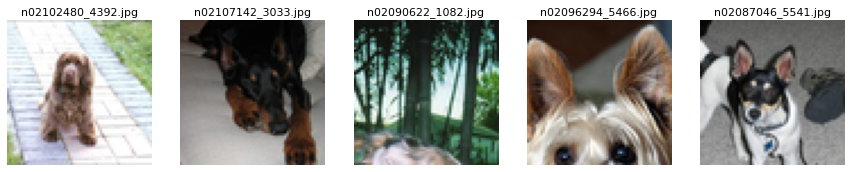

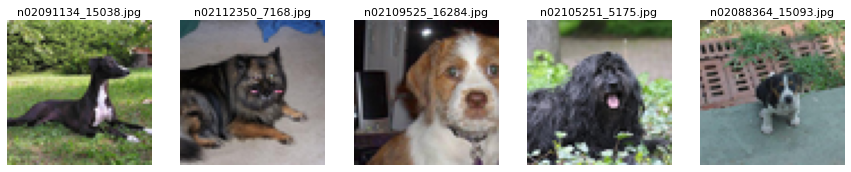

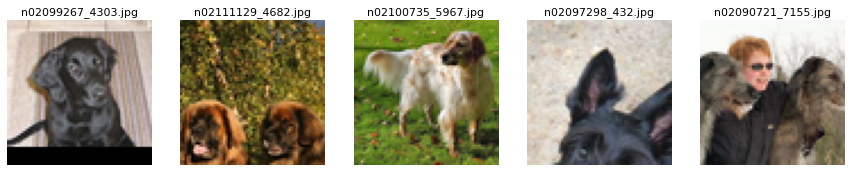

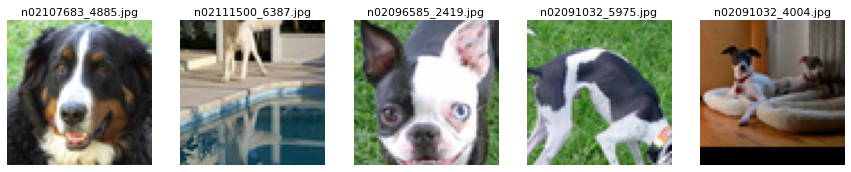

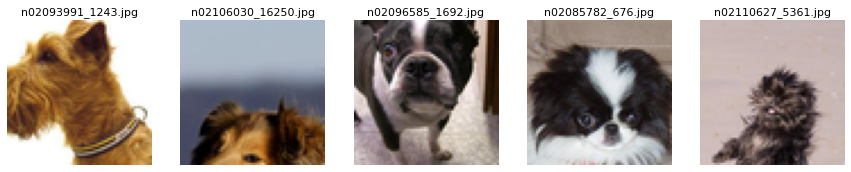

In [2]:
# crop and display images
ComputeLB = False
DogsOnly = False

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt, zipfile
from PIL import Image

ROOT = '../data/input/generative-dog-images/'
if not ComputeLB: ROOT = '../data/input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation') # 品种
 
idxIn = 0; namesIn = []
imagesIn = np.zeros((25000, 64, 64, 3))

# crop with bounding boxes to get dogs only
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT + 'annotation/Annotation/' + breed):
            try: img = Image.open(ROOT + 'all-dogs/all-dogs' + dog + '.jpg')
            except: continue
            tree = ET.parse(ROOT + 'annotation/Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64, 64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]

# randomly crop full images
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579), 10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2 == 0)|(k%3 == 0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0
        else:
            a = 0; b = 0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64) // 2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64) // 2

        img = img.resize((w2, h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])

        # if idxIn%1000==0: print(idxIn)
        idxIn += 1

# display cropped images
x = np.random.randint(0, idxIn, 25)
for k in range(5):
    plt.figure(figsize = (15, 3))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8'))
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]], fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1], fontsize=11)
        plt.imshow(img)
    plt.show()


In [3]:
# dataloader 
class dog_dataset(Dataset):
    def __init__(self, train_y, train_X, zeros, device):
        self.train_y = torch.Tensor(train_y).to(device)
        self.train_X = torch.Tensor(train_X).to(device)
        self.zeros = torch.Tensor(zeros).to(device)

    def __len__(self):
        return len(train_y)

    def __getitem__(self, idx):
        return self.train_y[idx], self.train_X[idx], self.zeros[idx]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bs = 256

train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1, 12288))
train_X = np.zeros((10000, 10000))
for i in range(10000): train_X[i, i] = 1
zeros = np.zeros((10000, 12288))

data_set = dog_dataset(train_y, train_X, zeros, device)
data_loader = DataLoader(data_set, bs)

In [6]:
# 完整性检查
print(train_y.shape, train_X.shape, zeros.shape)
print(train_y[0].shape, train_X[0].shape, zeros[0].shape)
print(len(train_y), len(train_X), len(zeros))

(10000, 12288) (10000, 10000) (10000, 12288)
(12288,) (10000,) (12288,)
10000 10000 10000


In [7]:
# Discriminator 
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(10000, 12288)
        self.conv1 = nn.Conv2d(1, 1, (2, 1), bias = False)

    def forward(self, imgs, imgnames):
        x = self.fc1(imgnames)
        x = torch.sigmoid(x)
        x = torch.cat((imgs, x), dim = 1).view(-1, 1, 2, 12288)
        x = self.conv1(x)
        return x.view(-1, 12288)

In [8]:
# train discriminator
lr = 0.005
epochs = 360
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=lr)
criteria = nn.BCELoss()
netD.conv1.weight = nn.Parameter(torch.Tensor(
    [[[[-1.0], [1.0]]]]
).to(device))

for param in netD.conv1.parameters():
    param.requires_grad = False


In [9]:
# train network
for k in tqdm(range(epochs)):
    for i, (y, X, Zeros) in enumerate(data_loader):
        netD.zero_grad()
        y_pred = netD(Zeros, X)
        loss = criteria(y_pred, y)
        loss.backward()
        optimizerD.step()
    if (k + 1) % 2 == 0:
        print(f"Epoch: {k + 1}/ {epochs} | Loss: {loss}")

Epoch: 2/ 360 | Loss: 0.6887545585632324
Epoch: 4/ 360 | Loss: 0.6761787533760071
Epoch: 6/ 360 | Loss: 0.6636412739753723
Epoch: 8/ 360 | Loss: 0.6519944071769714
Epoch: 10/ 360 | Loss: 0.6413118243217468
Epoch: 12/ 360 | Loss: 0.6315028667449951
Epoch: 14/ 360 | Loss: 0.6224837899208069
Epoch: 16/ 360 | Loss: 0.6141830086708069
Epoch: 18/ 360 | Loss: 0.6065371036529541
Epoch: 20/ 360 | Loss: 0.5994893908500671
Epoch: 22/ 360 | Loss: 0.5929890275001526
Epoch: 24/ 360 | Loss: 0.58698970079422
Epoch: 26/ 360 | Loss: 0.5814495086669922
Epoch: 28/ 360 | Loss: 0.5763302445411682
Epoch: 30/ 360 | Loss: 0.5715970396995544
Epoch: 32/ 360 | Loss: 0.5672181248664856
Epoch: 34/ 360 | Loss: 0.5631645321846008
Epoch: 36/ 360 | Loss: 0.5594098567962646
Epoch: 38/ 360 | Loss: 0.5559298396110535
Epoch: 40/ 360 | Loss: 0.5527023673057556
Epoch: 42/ 360 | Loss: 0.5497072339057922
Epoch: 44/ 360 | Loss: 0.5469258427619934
Epoch: 46/ 360 | Loss: 0.5443413853645325
Epoch: 48/ 360 | Loss: 0.541938245296478

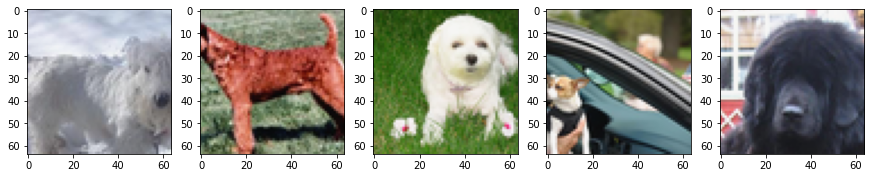

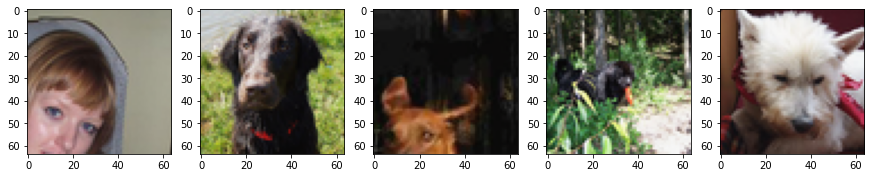

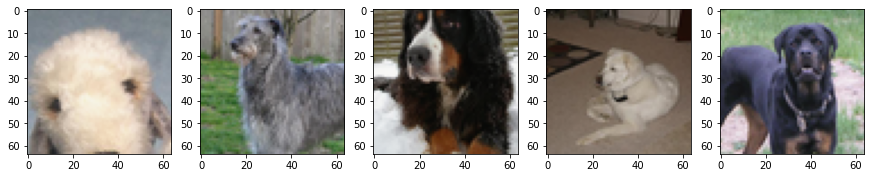

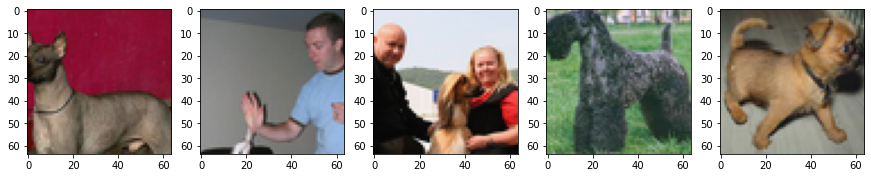

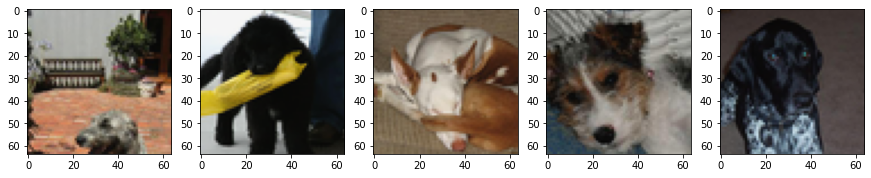

In [10]:
# discriminator recall from memory 
for k in range(5):
    plt.figure(figsize=(15, 3))
    for j in range(5):
        xx = torch.Tensor(np.zeros((10000))).to(device)
        xx[np.random.randint(10000)] = 1
        plt.subplot(1, 5, j+1)
        img = netD(torch.Tensor(zeros[0,:]).to(device).reshape((-1, 12288)), xx.reshape((-1, 10000))).reshape((-1, 64, 64, 3))
        img = img.detach().cpu().numpy()
        img = Image.fromarray((255 * img).astype('uint8').reshape((64, 64, 3)))
        plt.imshow(img)

    plt.show()

In [14]:
# Generator
class Generator(nn.ModuleList):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(10000, 12288)

    def forward(self, imgnames):
        x = self.fc1(imgnames)
        return x, imgnames.view(-1, 10000)

In [ ]:
def show_image():
    plt.figure(figsize=(15, 3))
    for j in range(5):
        with torch.no_grad():
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1, 5, j+1)
            inp = torch.Tensor(xx.reshape((-1, 10000))).to(device)
            img = netG(inp)[0].reshape((-1, 64, 64, 3)).to("cpu").clone().detach().numpy()
            img = Image.fromarray((img).astype('uint8').reshape((64, 64, 3)))
            